In [1]:
import tensorflow as tf
import FinanceDataReader as fdr
import csv
import numpy as np
from tensorflow.contrib import rnn
import matplotlib
import os
import matplotlib.pyplot as plt
import datetime
import time

fdr.__version__

'0.7.1'

In [2]:
def write_file(data_list, file_name):
    with open(file_name,'w', newline='') as f:
        data_list = np.array(data_list)
        writer = csv.writer(f)
        writer.writerows(data_list)
    return

def MinMaxScaler(data):
    for i in range (0, len(data)):
        data[i, 0] = time.mktime(data[i, 0].timetuple())
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

def extract_x_and_y(data, sequence_length):
    data_x = []
    data_y = []
    time_stamp_y = []
    for i in range(0, len(data) - sequence_length + 1):
        x = data[i:i + sequence_length]
        y_index = i + sequence_length
        if y_index < len(data):
            y = data[y_index]
            time_stamp_y.append(data[y_index, [0]])
            data_y.append(y)
        data_x.append(x)
    return np.array(data_x), np.array(data_y), np.array(time_stamp_y), data

def extract_x_and_y_for_training(data, sequence_length):
    data_x = []
    data_y = []
    time_stamp_y = []
    for i in range(0, len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y_index = i + sequence_length
        y = data[y_index]
        
        time_stamp_y.append(data[y_index, [0]])
        data_x.append(x)
        data_y.append(y)
    return np.array(data_x), np.array(data_y), np.array(time_stamp_y)

def lstm_cell(hidden_size):
    cell = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
    return cell

def getDailyStockPriceData(code, startDate, endDate, sequence_length, isTraining = False):
    data = np.array(fdr.DataReader(code, startDate, endDate))
    data = MinMaxScaler(data[:, :-1]) #날짜 시작가격, 최고가, 최적가, 종가, 거래량
    if isTraining == False:
        return extract_x_and_y(data, sequence_length)
    else:
        return extract_x_and_y_for_training(data, sequence_length)

def getActualDailyPrices(code, startDate, endDate):
    data = np.array(fdr.DataReader(code, startDate, endDate))
    return MinMaxScaler(data[:, :-1])

def get_predict_data_of_last_date(x, sess):
    outputs = sess.run(Y_pred, feed_dict={X: x})
    return outputs[-1:]

def retrain_with_outputs(data, x_data, sequence_length, addtional_batch_count, sess):
    print("data: {} x_data {}".format(data.shape, x_data.shape))
    for i in range(0, addtional_batch_count):
        predict_of_last = get_predict_data_of_last_date(x_data, sess)
        data = np.append(data, predict_of_last, axis=0)
        x_data , y_data ,_ ,_ = extract_x_and_y(data, sequence_length)
    print("result: {} {}".format(x_data.shape, y_data.shape))
    return data

In [3]:
def runTestData(code, end_date_of_test_data, start_date_to_predict, end_date_to_predict, sequence_length, sess):
    print("Run test data. code: {}  {} ~ {}".format(code, start_date_to_predict, end_date_to_predict))
    
    actual_y = getActualDailyPrices(code, start_date_to_predict, end_date_to_predict)
    days_to_predict = len(actual_y)
    print("length of days to predict: {}".format(days_to_predict))
    
    test_data_x, test_data_y, test_data_time_stamp_y, data = getDailyStockPriceData(code, '1992-01-01', end_date_of_test_data, sequence_length, False)
    outputs = retrain_with_outputs(data, test_data_x, sequence_length, days_to_predict, sess)
    expected_prices = actual_y[:, 4:5]
    predict_prices = outputs[-days_to_predict:, 4:5]
    
    plt.title("Actual vs Predicted")
    plt.plot(expected_prices)
    plt.plot(predict_prices)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
    
    rmse_val = sess.run(rmse, feed_dict={expected_results: actual_y, predictions: outputs[-days_to_predict:,]})
    print("RMSE: {} \n\n".format(rmse_val))

In [4]:
def train(code_to_train, start_date, end_date, sequence_length, learning_rate = 0.01, train_iteration_count = 1000, sess = tf.Session()):
    tf.reset_default_graph()
    
    #Hyper Params
    data_dim = 6
    hidden_dim = 10
    num_classes = 6
    batch_size = None
    
    global X, Y, Y_pred, cells, loss, train_op, expected_results, predictions, rmse
    
    X = tf.placeholder(tf.float32, [batch_size, sequence_length, data_dim])
    Y = tf.placeholder(tf.float32, [batch_size, num_classes])
    
    cells = rnn.MultiRNNCell([lstm_cell(hidden_dim) for _ in range(2)], state_is_tuple=True)
    outputs, _states = tf.nn.dynamic_rnn(cells, X, dtype=tf.float32)

    # FC layer
    X_for_fc = tf.reshape(outputs, [-1, hidden_dim])
    outputs = tf.contrib.layers.fully_connected(X_for_fc, num_classes, activation_fn=tf.tanh)
    # reshape out for sequence_loss
    outputs = tf.reshape(outputs, [-1, sequence_length, num_classes])

    # We use the last cell's output
    Y_pred = outputs[:, -1]

    loss = tf.reduce_sum(tf.square(Y_pred[:, 4:5] - Y[:, 4:5]))
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    # RMSE
    expected_results = tf.placeholder(tf.float32, [batch_size, num_classes])
    predictions = tf.placeholder(tf.float32, [batch_size, num_classes])
    rmse = tf.sqrt(tf.reduce_mean(tf.square(expected_results[:, 4:5] - predictions[:, 4:5])))
    
    #Training Set #1
    data_x, data_y, time_stamp_y = getDailyStockPriceData(code_to_train, start_date, end_date, sequence_length, True)
    training_set = [[data_x, data_y]]
    
    
    #Run training
    sess = tf.Session()
    saver = tf.train.Saver()
    ckpt_path = './daily_stock_prediction_model_{}.ckpt'.format(code_to_train)
    try:
        saver.restore(sess, ckpt_path)
    except Exception as e:
        sess.run(tf.global_variables_initializer())

    init_loss = 100
    for t in range (0, len(training_set)):
        print("training set #", t)
        x = training_set[t][0]
        y = training_set[t][1]
        print("x shape: {}".format(x.shape))
        print("y shape: {}".format(y.shape))
        init_loss = sess.run(loss, feed_dict={X: x, Y: y})
        print("init loss: {}".format(init_loss))
        for i in range(train_iteration_count):
            _, step_loss = sess.run([train_op, loss], feed_dict={X: x, Y: y})
            if (i + 1) % 100 == 0:
                print("[#{} step: {}] loss: {}".format(t, i, step_loss))
    
    #Save check point
    saver = tf.train.Saver()
    if step_loss < init_loss:
        print("Saved check point init loss: {} current loss: {}".format(init_loss, step_loss))
        saver.save(sess, ckpt_path)
    else:
        print("Did not make check point. init loss: {} current loss{}".format(init_loss, step_loss))
    
    #Compare tarining x and y
    predict = sess.run(Y_pred, feed_dict={X: data_x})
    prdict_end_prices = predict[:,4:5]
    expected_end_prices = data_y[:,4:5]
    rmse_val = sess.run(rmse, feed_dict={expected_results: data_y, predictions: predict})
    print("RMSE: {}  date range: {}~{}".format(rmse_val, start_date, end_date))

    # Both
    plt.title('predicted vs expected(actual) prices')
    plt.plot(prdict_end_prices)
    plt.plot(expected_end_prices)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()    
    
    print("Run test prediction \n")   
    testCodes = ['005930', "066570", '041510']
    for index, c in enumerate(testCodes):
        runTestData(c, '2018-11-30', '2018-12-01', '2019-01-06', sequence_length, sess)
    

INFO:tensorflow:Restoring parameters from ./daily_stock_prediction_model_066570.ckpt
training set # 0
x shape: (4081, 30, 6)
y shape: (4081, 6)
init loss: 0.2978958785533905
Did not make check point. init loss: 0.2978958785533905 current loss0.2978958785533905
RMSE: 0.008543694391846657  date range: 1992-01-01~2018-11-30


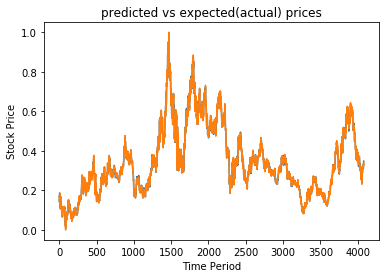

Run test prediction 

Run test data. code: 005930  2018-12-01 ~ 2019-01-06
length of days to predict: 22
data: (5978, 6) x_data (5949, 30, 6)
result: (5971, 30, 6) (5970, 6)


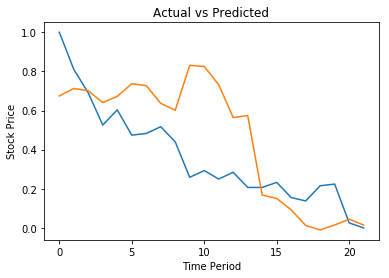

RMSE: 0.25949954986572266 


Run test data. code: 066570  2018-12-01 ~ 2019-01-06
length of days to predict: 22
data: (4111, 6) x_data (4082, 30, 6)
result: (4104, 30, 6) (4103, 6)


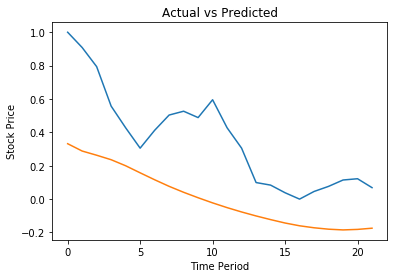

RMSE: 0.38605543971061707 


Run test data. code: 041510  2018-12-01 ~ 2019-01-06
length of days to predict: 22
data: (4593, 6) x_data (4564, 30, 6)
result: (4586, 30, 6) (4585, 6)


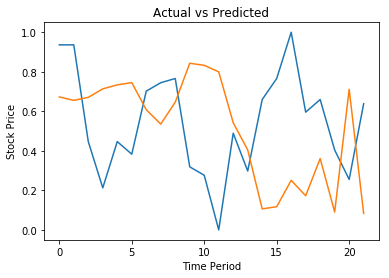

RMSE: 0.43364372849464417 




In [5]:
sess = tf.Session()
code = "066570"
sequence_length = 30
train(code, '1992-01-01', '2018-11-30', sequence_length, 0.0001, 1, sess)

INFO:tensorflow:Restoring parameters from ./daily_stock_prediction_model_005930.ckpt
training set # 0
x shape: (5948, 30, 6)
y shape: (5948, 6)
init loss: 0.21663504838943481
Did not make check point. init loss: 0.21663504838943481 current loss0.21663504838943481
RMSE: 0.006034955848008394  date range: 1992-01-01~2018-11-30


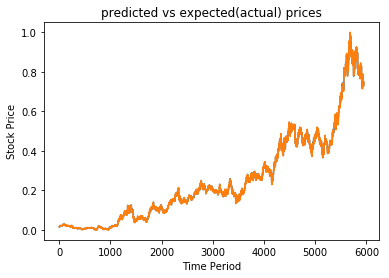

Run test prediction 

Run test data. code: 005930  2018-12-01 ~ 2019-01-06
length of days to predict: 22
data: (5978, 6) x_data (5949, 30, 6)
result: (5971, 30, 6) (5970, 6)


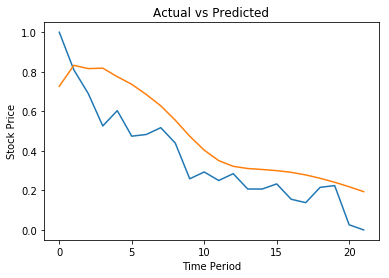

RMSE: 0.15840111672878265 


Run test data. code: 066570  2018-12-01 ~ 2019-01-06
length of days to predict: 22
data: (4111, 6) x_data (4082, 30, 6)
result: (4104, 30, 6) (4103, 6)


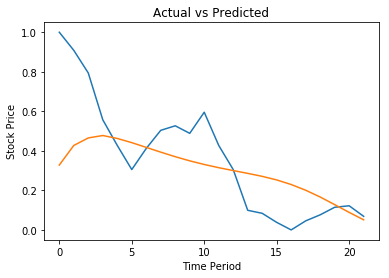

RMSE: 0.22944054007530212 


Run test data. code: 041510  2018-12-01 ~ 2019-01-06
length of days to predict: 22
data: (4593, 6) x_data (4564, 30, 6)
result: (4586, 30, 6) (4585, 6)


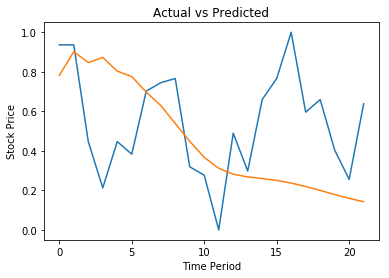

RMSE: 0.3566652238368988 




In [6]:
code = '005930'
train(code, '1992-01-01', '2018-11-30', sequence_length, 0.0001, 1, sess)